In [1]:
import sys
sys.path.insert(0, '../Utilities/')

import torch
from collections import OrderedDict

from doe_lhs import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
# from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
from torch.utils.data import TensorDataset, DataLoader

np.random.seed(1234)

In [2]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

# Physics-informed Neural Networks

In [3]:
# the deep neural network
class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

In [4]:
# the physics-guided neural network
class PhysicsInformedNN():
    def __init__(self, X_u, u, X_f, layers, X_lb, X_ub,device):
        
        self.batch_size = 100000
        
        
        # boundary conditions
        self.X_lb = X_lb
        self.X_ub = X_ub
        
        self.device = device
        
        # data
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        self.u = torch.tensor(u).float().to(device)
        
        self.layers = layers
        
        # deep neural networks
        self.dnn = DNN(layers).to(device)
        
        # optimizers: using the same settings
        self.optimizer = torch.optim.LBFGS(
            self.dnn.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"       # can be "strong_wolfe"
        )
        
        self.Adam_optim = torch.optim.Adam(
            self.dnn.parameters(),
            lr = 1e-4
        )

        self.iter = 0
        
        shuffle = True
        self.train_loader = DataLoader(
            list(zip(self.x_u,
                     self.t_u,
                     self.u)), batch_size=self.batch_size, shuffle=shuffle
        )
        
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        
        h = self.net_u(x, t)
        u = h[:,0:1]
        v = h[:,1:2]
        
        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_t = torch.autograd.grad(
            v, t, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_x = torch.autograd.grad(
            v, x, 
            grad_outputs=torch.ones_like(v),
            retain_graph=True,
            create_graph=True
        )[0]
        
        v_xx = torch.autograd.grad(
            v_x, x, 
            grad_outputs=torch.ones_like(v_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f_u = u_t + 0.5*v_xx + (u**2 + v**2)*v
        f_v = v_t - 0.5*u_xx - (u**2 + v**2)*u 
        return h,f_u, f_v
    
    def boundary_loss(self):
        
        x_lb = torch.tensor(self.X_lb[:, 0:1], requires_grad=True).float().to(self.device)
        t_lb = torch.tensor(self.X_lb[:, 1:2], requires_grad=True).float().to(self.device)

        x_ub = torch.tensor(self.X_ub[:, 0:1], requires_grad=True).float().to(self.device)
        t_ub = torch.tensor(self.X_ub[:, 1:2], requires_grad=True).float().to(self.device)
        
        y_pred_lb = self.dnn.forward(torch.cat([x_lb, t_lb], dim=1))
        y_pred_ub = self.dnn.forward(torch.cat([x_ub, t_ub], dim=1))
        
        u_lb = y_pred_lb[:,0:1]
        v_lb = y_pred_lb[:,1:2]
        u_ub = y_pred_ub[:,0:1]
        v_ub = y_pred_ub[:,1:2]
        
        u_lb_x = torch.autograd.grad(
                u_lb, x_lb, 
                grad_outputs=torch.ones_like(u_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        u_ub_x = torch.autograd.grad(
                u_ub, x_ub, 
                grad_outputs=torch.ones_like(u_ub),
                retain_graph=True,
                create_graph=True
            )[0]

        v_lb_x = torch.autograd.grad(
                v_lb, x_lb, 
                grad_outputs=torch.ones_like(v_lb),
                retain_graph=True,
                create_graph=True
            )[0]

        v_ub_x = torch.autograd.grad(
                v_ub, x_ub, 
                grad_outputs=torch.ones_like(v_ub),
                retain_graph=True,
                create_graph=True
            )[0]
        
        loss = torch.mean((y_pred_lb - y_pred_ub)**2) + \
               torch.mean((u_lb_x - u_ub_x)**2) + \
               torch.mean((v_lb_x - v_ub_x)**2)
        
        return loss
    
    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_u, self.t_u)
        _, f_u, f_v = self.net_f(self.x_f, self.t_f)
        loss_u = torch.mean((self.u - u_pred) ** 2)
        loss_f = torch.mean(f_u**2 + f_v**2)
        
        b_loss = self.boundary_loss()
        
        loss = loss_u + loss_f + b_loss
        
        loss.backward()
        self.iter += 1
        if self.iter % 100 == 0:
            print(
                'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
            )
        return loss
    
    def train(self, epoch = 10000):
        self.train_1(epoch)
        self.train_2()
    
    def train_1(self,epoch):
        for e in range(epoch):
            
            for i, (x, t, y) in enumerate(self.train_loader):
            
            
                self.dnn.train()
                self.optimizer.zero_grad()

                u_pred = self.net_u(x, t)
#                 u_pred = self.net_u(self.x_u, self.t_u)
                _, f_u, f_v = self.net_f(self.x_f, self.t_f)
                loss_u = torch.mean((y - u_pred) ** 2)
                loss_f = torch.mean(f_u**2 + f_v**2)
                b_loss = self.boundary_loss()

                loss = loss_u + loss_f + b_loss

                loss.backward(retain_graph = True)
                self.Adam_optim.step()


                self.iter += 1
                if self.iter % 100 == 0:
                    print(
                        'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                    )

    def train_2(self):
        self.dnn.train()
        self.optimizer.step(self.loss_func)
            
    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device)
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval()
        u = self.net_u(x, t)
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

In [5]:
N0 = 50
N_b = 50
N_f = 20000
layers = [2, 100, 100, 100, 100, 2]

data = scipy.io.loadmat('../../../datasets/NLS.mat')

t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = data['uu']
Exact_u = np.real(Exact)
Exact_v = np.imag(Exact)
Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)

X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact_u.T.flatten()[:,None]
v_star = Exact_v.T.flatten()[:,None]
h_star = Exact_h.T.flatten()[:,None]

###########################

idx_x = np.random.choice(x.shape[0], N0, replace=False)
x0 = x[idx_x,:]
u0 = Exact_u[idx_x,0:1]
v0 = Exact_v[idx_x,0:1]

lb = X_star.min(0)
ub = X_star.max(0) 

idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t,:]

X_f = lb + (ub-lb)*lhs(2, N_f)

X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
Y0 = np.concatenate((u0,v0), 1) 
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)              

In [6]:
model = PhysicsInformedNN(X0, Y0, X_f, layers, X_lb,X_ub,device)

In [7]:
%%time
model.train()

Iter 100, Loss: 1.11349e-01, Loss_u: 9.05007e-02, Loss_f: 1.58309e-02
Iter 200, Loss: 8.10184e-02, Loss_u: 5.66001e-02, Loss_f: 2.24534e-02
Iter 300, Loss: 7.11862e-02, Loss_u: 4.89454e-02, Loss_f: 2.12296e-02
Iter 400, Loss: 6.16804e-02, Loss_u: 4.28384e-02, Loss_f: 1.82354e-02
Iter 500, Loss: 5.01007e-02, Loss_u: 3.35693e-02, Loss_f: 1.61854e-02
Iter 600, Loss: 4.49740e-02, Loss_u: 2.77817e-02, Loss_f: 1.69876e-02
Iter 700, Loss: 4.30822e-02, Loss_u: 2.60439e-02, Loss_f: 1.69376e-02
Iter 800, Loss: 4.18105e-02, Loss_u: 2.50789e-02, Loss_f: 1.66604e-02
Iter 900, Loss: 4.07097e-02, Loss_u: 2.43526e-02, Loss_f: 1.62742e-02
Iter 1000, Loss: 3.96149e-02, Loss_u: 2.36864e-02, Loss_f: 1.58731e-02
Iter 1100, Loss: 3.85371e-02, Loss_u: 2.30350e-02, Loss_f: 1.54465e-02
Iter 1200, Loss: 3.75181e-02, Loss_u: 2.23217e-02, Loss_f: 1.50753e-02
Iter 1300, Loss: 3.63985e-02, Loss_u: 2.16537e-02, Loss_f: 1.46852e-02
Iter 1400, Loss: 3.53694e-02, Loss_u: 2.09613e-02, Loss_f: 1.43426e-02
Iter 1500, Loss

Iter 11700, Loss: 2.78630e-04, Loss_u: 4.15555e-05, Loss_f: 2.32875e-04
Iter 11800, Loss: 2.49876e-04, Loss_u: 3.61366e-05, Loss_f: 2.08362e-04
Iter 11900, Loss: 2.25340e-04, Loss_u: 3.78300e-05, Loss_f: 1.83975e-04
Iter 12000, Loss: 1.98919e-04, Loss_u: 3.07185e-05, Loss_f: 1.66517e-04
Iter 12100, Loss: 1.81170e-04, Loss_u: 2.60509e-05, Loss_f: 1.53433e-04
Iter 12200, Loss: 1.65696e-04, Loss_u: 2.42278e-05, Loss_f: 1.39037e-04
Iter 12300, Loss: 1.49656e-04, Loss_u: 2.30385e-05, Loss_f: 1.25012e-04
Iter 12400, Loss: 1.36548e-04, Loss_u: 2.04149e-05, Loss_f: 1.14651e-04
Iter 12500, Loss: 1.23540e-04, Loss_u: 1.63345e-05, Loss_f: 1.06085e-04
Iter 12600, Loss: 1.13552e-04, Loss_u: 1.29098e-05, Loss_f: 9.94289e-05
Iter 12700, Loss: 1.06102e-04, Loss_u: 1.09838e-05, Loss_f: 9.38968e-05
Iter 12800, Loss: 9.97333e-05, Loss_u: 1.00231e-05, Loss_f: 8.81486e-05
Iter 12900, Loss: 9.26326e-05, Loss_u: 9.13589e-06, Loss_f: 8.18587e-05
Iter 13000, Loss: 8.71678e-05, Loss_u: 8.77964e-06, Loss_f: 7.67

In [8]:
nsamples = 1
u_pred_list = []
v_pred_list = []
h_pred_list = []
f_u_pred_list = []
f_v_pred_list = []

x = torch.tensor(X_star[:,0:1], requires_grad=True).float().to(device)
t = torch.tensor(X_star[:,1:2], requires_grad=True).float().to(device)

for run in range(nsamples):
    y_pred, f_u_pred, f_v_pred = model.net_f(x,t)
    u_pred = y_pred[:,0:1].detach().cpu().numpy()
    v_pred = y_pred[:,1:2].detach().cpu().numpy()
    h_pred = np.sqrt(u_pred**2 + v_pred**2)
    u_pred_list.append(u_pred)
    v_pred_list.append(v_pred)
    f_u_pred_list.append(f_u_pred.detach().cpu().numpy())
    f_v_pred_list.append(f_v_pred.detach().cpu().numpy())
    h_pred_list.append(h_pred)


u_pred_arr = np.array(u_pred_list)
v_pred_arr = np.array(v_pred_list)
f_u_pred_arr = np.array(f_u_pred_list)
f_v_pred_arr = np.array(f_v_pred_list)
h_pred_arr = np.array(h_pred_list)

u_pred = u_pred_arr.mean(axis=0)
v_pred = v_pred_arr.mean(axis=0)
f_u_pred = f_u_pred_arr.mean(axis=0)
f_v_pred = f_v_pred_arr.mean(axis=0)
h_pred = h_pred_arr.mean(axis=0)

h_pred_var = h_pred_arr.var(axis=0)
residual = (f_u_pred**2).mean() + (f_v_pred**2).mean()

#     u_dev = u_pred_arr.var(axis=0)
#     f_dev = f_pred_arr.var(axis=0)

error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
error_v = np.linalg.norm(v_star-v_pred,2)/np.linalg.norm(v_star,2)
error_h = np.linalg.norm(h_star-h_pred,2)/np.linalg.norm(h_star,2)


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
V_pred = griddata(X_star, v_pred.flatten(), (X, T), method='cubic')
H_pred = griddata(X_star, h_pred.flatten(), (X, T), method='cubic')
H_pred_var = griddata(X_star, h_pred_var.flatten(), (X, T), method='cubic')
FU_pred = griddata(X_star, f_u_pred.flatten(), (X, T), method='cubic')
FV_pred = griddata(X_star, f_v_pred.flatten(), (X, T), method='cubic')

In [9]:
print("Error u:", error_u)
print("Error v:", error_v)
print("Error h:", error_h)                   
print('Residual: %e' % (residual))

Error u: 0.004187099126891304
Error v: 0.006187286759677173
Error h: 0.001876017927523178
Residual: 6.252789e-06


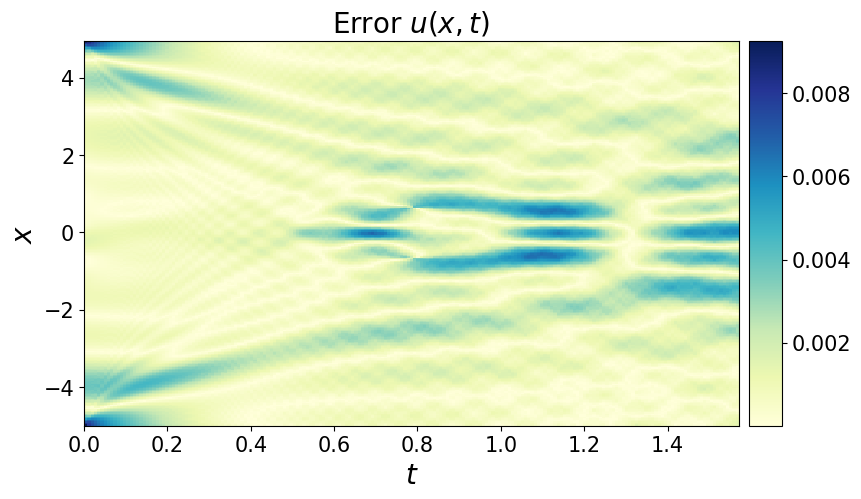

In [10]:
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact_h - H_pred.T)
""" The aesthetic setting has changed. """


xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# boundary conditions x = lb
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# boundary conditions, x = ub
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx2, xx3]) 


####### Row 0: u(t,x) ##################    
X_u_train_ = X_u_train

####### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
t = data['tt'].flatten()[:,None]
x = data['x'].flatten()[:,None]

h = ax.imshow(Error, interpolation='nearest', cmap='YlGnBu', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')

# h = ax.imshow(H_pred.T, interpolation='nearest', cmap='rainbow', 
#               extent=[t.min(), t.max(), x.min(), x.max()], 
#               origin='lower', aspect='auto')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

# ax.plot(
#     X_u_train_[:,1], 
#     X_u_train_[:,0], 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# )


ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
# ax.legend(
#     loc='upper center', 
#     bbox_to_anchor=(0.9, -0.05), 
#     ncol=5, 
#     frameon=False, 
#     prop={'size': 15}
# )
ax.set_title('Error $u(x,t)$', fontsize = 20) # font size doubled
ax.tick_params(labelsize=15)

plt.savefig('std_schrodinger.svg',dpi = 600, bbox_inches = 'tight')
plt.show()